# Automatic emittance measurement at LCLS-II
In this case we have 4 quadrupoles, 3 that are used to minimize the incoming beam and
 the fourth to perform the quad scan measurement.

In [1]:
from scripts.evaluate_function.lcls_ii_injector import measure_beamsize, measure_background
from scripts.optimize_function import optimize_function
from scripts.characterize_emittance import characterize_emittance

In [2]:
## import variable ranges
import pandas as pd
filename = "../../variables.csv"
VARIABLE_RANGES = pd.read_csv(filename, index_col=0, header=None).T.to_dict(orient='list')
SCREEN_NAME = "OTRS:HTR:330"

## (Optional) Measure background image

In [3]:
MEASURE_BACKGROUND = True
if MEASURE_BACKGROUND:
    measure_background(SCREEN_NAME)
    BACKGROUND_FILE = f"{SCREEN_NAME}_background.npy".replace(":","_")
else:
    BACKGROUND_FILE = None

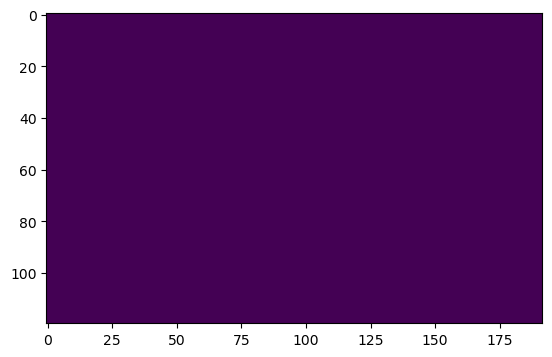

In [4]:
# verify background image
import numpy as np
import matplotlib.pyplot as plt
plt.imshow(np.load(BACKGROUND_FILE))

## Define measurement parameters

In [5]:
from xopt import VOCS
import numpy as np


TUNING_VARIABLES = ["QUAD:HTR:120:BCTRL","QUAD:HTR:140:BCTRL","QUAD:HTR:300:BCTRL"]
SCAN_VARIABLE = "QUAD:HTR:320:BCTRL"
QUAD_LENGTH = 1.0 # m
DRIFT_LENGTH = 1.0 # m
BEAM_ENERGY = 0.135 # GeV
PV_TO_INTEGRATED_GRADIENT = 1.0 # kG
ROI = None
THRESHOLD = 3000

# define function to measure the total size on OTR4
def eval_beamsize(input_dict):
    results = measure_beamsize(input_dict)
    results["S_x_mm"] = results["Sx"] * 1e3
    results["S_y_mm"] = results["Sy"] * 1e3

    #add total beam size
    results["total_size"] = np.sqrt(results["Sx"]**2 + results["Sy"]**2)
    return results



## Optimize upstream beam parameters to minimze beamsize
Note that the scan variable is fixed at zero for maximum range quadrupole scan.

C:\Users\Ryan Roussel\mambaforge\envs\emittance_bax\lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\Ryan Roussel\mambaforge\envs\emittance_bax\lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\Ryan Roussel\mambaforge\envs\emittance_bax\lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


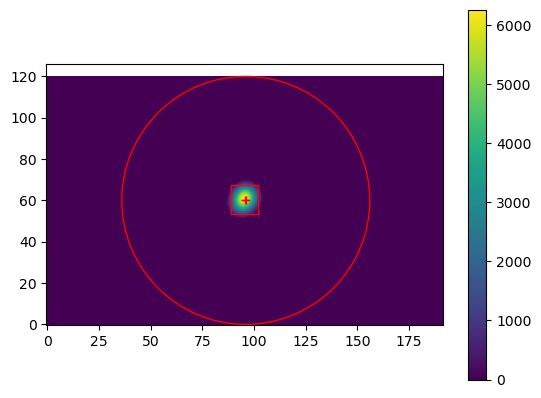

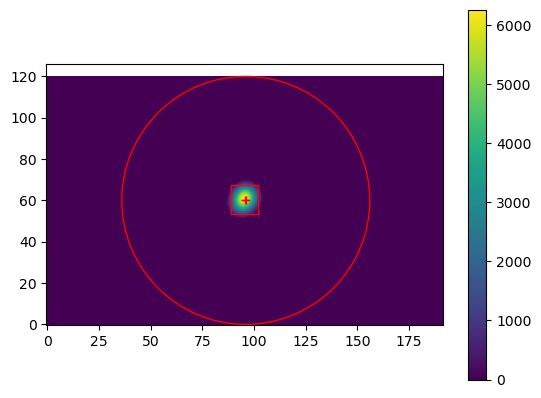

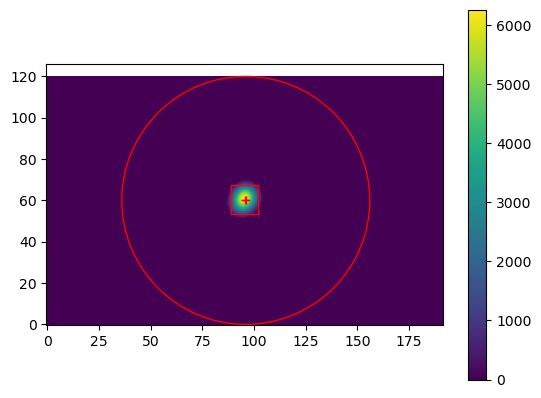

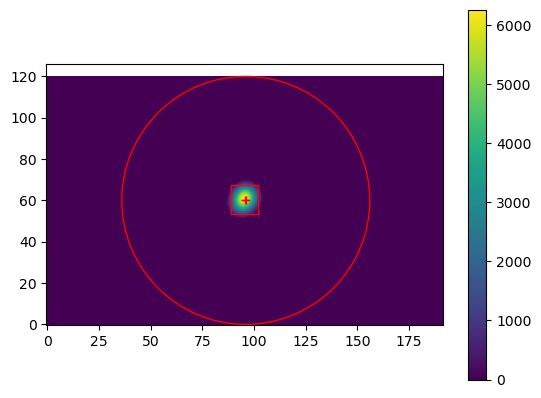

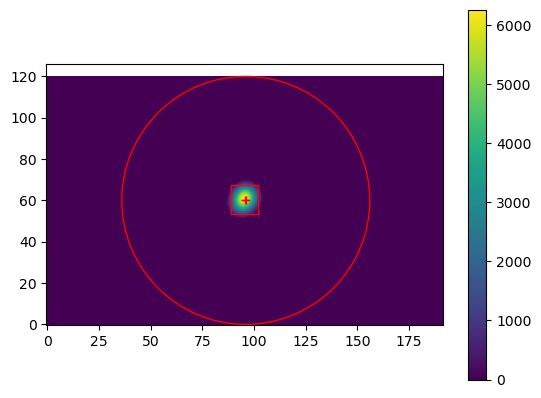

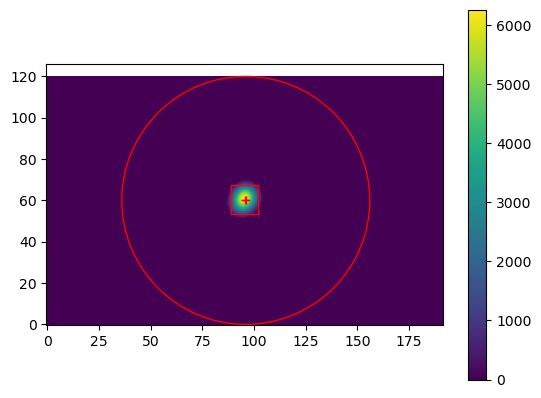

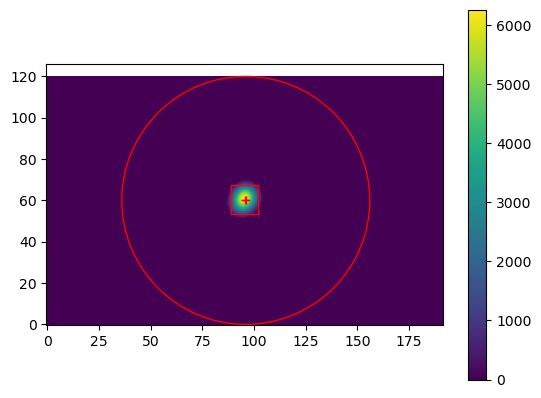

In [6]:
opt_vocs = VOCS(
        variables = {ele: VARIABLE_RANGES[ele] for ele in TUNING_VARIABLES},
        constants = {
            SCAN_VARIABLE: 0.0,
            "screen": SCREEN_NAME,
            "background": BACKGROUND_FILE,
            "threshold": THRESHOLD,
            "roi": ROI,
            "visualize": True
        },
        constraints = {
            "bb_penalty": ["LESS_THAN", 0.0],
            "log10_total_intensity": ["GREATER_THAN", 4]
        },
        objectives = {"total_size": "MINIMIZE"}

    )

opt_x = optimize_function(
    opt_vocs, eval_beamsize, n_iterations=1,
)

In [7]:
opt_x.data

,QUAD:HTR:120:BCTRL,QUAD:HTR:140:BCTRL,QUAD:HTR:300:BCTRL,QUAD:HTR:320:BCTRL,screen,background,threshold,roi,visualize,Cx,...,Sy,bb_penalty,total_intensity,log10_total_intensity,time,S_x_mm,S_y_mm,total_size,xopt_runtime,xopt_error
1,-0.198613,-2.013342,2.846151,0.0,OTRS:HTR:330,OTRS_HTR_330_background.npy,3000,None,True,95.447214,...,3.484292,-0.145952,567843.729286,5.754229,1.689350e+09,3261.797757,3484.291705,4.772799,1.037744,False
2,3.747874,1.449869,1.060407,0.0,OTRS:HTR:330,OTRS_HTR_330_background.npy,3000,None,True,95.447214,...,3.484292,-0.145952,567843.729286,5.754229,1.689350e+09,3261.797757,3484.291705,4.772799,1.036404,False
3,2.121915,-3.919025,-3.335748,0.0,OTRS:HTR:330,OTRS_HTR_330_background.npy,3000,None,True,95.447214,...,3.484292,-0.145952,567843.729286,5.754229,1.689350e+09,3261.797757,3484.291705,4.772799,1.047465,False
4,-3.463672,-2.474513,-2.045297,0.0,OTRS:HTR:330,OTRS_HTR_330_background.npy,3000,None,True,95.447214,...,3.484292,-0.145952,567843.729286,5.754229,1.689350e+09,3261.797757,3484.291705,4.772799,1.047507,False
5,0.452311,4.033622,-4.181391,0.0,OTRS:HTR:330,OTRS_HTR_330_background.npy,3000,None,True,95.447214,...,3.484292,-0.145952,567843.729286,5.754229,1.689350e+09,3261.797757,3484.291705,4.772799,1.033658,False
6,-4.480350,4.476200,4.469200,0.0,OTRS:HTR:330,OTRS_HTR_330_background.npy,3000,None,True,95.447214,...,3.484292,-0.145952,567843.729286,5.754229,1.689350e+09,3261.797757,3484.291705,4.772799,1.035536,False
7,-0.198613,-2.013342,2.846151,0.0,OTRS:HTR:330,OTRS_HTR_330_background.npy,3000,None,True,95.447214,...,3.484292,-0.145952,567843.729286,5.754229,1.689350e+09,3261.797757,3484.291705,4.772799,1.042162,False


## Automatic quad scan and emittance characterization

In [15]:
from emitopt.utils import get_quad_strength_conversion_factor
emit_vocs = VOCS(
        variables = {SCAN_VARIABLE: VARIABLE_RANGES[SCAN_VARIABLE]},
        observables = ["S_x_mm", "S_y_mm"],
        constraints = {
            "bb_penalty": ["LESS_THAN", 0.0],
            "log10_total_intensity": ["GREATER_THAN", 4]
        },
        constants = opt_x.data.iloc[-1][TUNING_VARIABLES].to_dict() | {
            "screen": SCREEN_NAME,
            "background": BACKGROUND_FILE,
            "threshold": THRESHOLD,
            "roi": ROI
        }
    )

# create conversion factor from PV value to geometric focusing strength
integrated_gradient_to_geometric_focusing_strength = get_quad_strength_conversion_factor(
        BEAM_ENERGY, QUAD_LENGTH
    )
quad_strength_scale_factor =  PV_TO_INTEGRATED_GRADIENT * integrated_gradient_to_geometric_focusing_strength

emit_results, emit_Xopt = characterize_emittance(
    emit_vocs,
    eval_beamsize,
    QUAD_LENGTH,
    DRIFT_LENGTH,
    quad_strength_key=SCAN_VARIABLE,
    quad_strength_scale_factor=quad_strength_scale_factor,
    rms_x_key="S_x_mm",
    rms_y_key="S_y_mm",
    quad_scan_analysis_kwargs={"visualize": True}
)

C:\Users\Ryan Roussel\mambaforge\envs\emittance_bax\lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\Ryan Roussel\mambaforge\envs\emittance_bax\lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\Ryan Roussel\mambaforge\envs\emittance_bax\lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\Ryan Roussel\mambaforge\envs\emittance_bax\lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and un

UnboundLocalError: local variable 'result' referenced before assignment

In [ ]:
emit_results

In [ ]:
emit_Xopt.data